## Buy Now, Pay Later Project
### MAST30034: Applied Data Science 
#### Notebook 2: Preprocessing Data 2: Missing Value and Outliers Detection

In [1]:
# create modeling spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('Project 2 test')
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/08 12:27:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/08 12:27:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
full = spark.read.parquet('../data/curated/full_dataset/')
full


postcode,merchant_abn,user_id,consumer_id,state,gender,dollar_value,order_datetime,business_area,revenue_level,take_rate,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size
3332,96161947306,14,1343547,VIC,Male,112.67012437787673,2021-08-20,shoe shops,b,4.52,38,1733,797,350,2096,0.8,1955,2.9
3332,75900778714,14,1343547,VIC,Male,546.6848295784864,2021-08-20,florists supplies...,c,2.61,38,1733,797,350,2096,0.8,1955,2.9
3332,68216911708,14,1343547,VIC,Male,32.90127154333186,2021-08-20,"computers, comput...",c,3.05,38,1733,797,350,2096,0.8,1955,2.9
3332,20985347699,14,1343547,VIC,Male,0.27083188402634917,2021-08-21,tent and awning s...,a,6.10,38,1733,797,350,2096,0.8,1955,2.9
3332,45629217853,14,1343547,VIC,Male,8.204284579030558,2021-08-14,"gift, card, novel...",a,6.98,38,1733,797,350,2096,0.8,1955,2.9
3332,92308095254,14,1343547,VIC,Male,102.3328793223507,2021-07-15,"gift, card, novel...",a,6.53,38,1733,797,350,2096,0.8,1955,2.9
3332,17678252870,14,1343547,VIC,Male,36.297748446791886,2021-08-16,"watch, clock, and...",c,2.07,38,1733,797,350,2096,0.8,1955,2.9
3332,64203420245,14,1343547,VIC,Male,53.08523476846913,2021-08-16,tent and awning s...,c,2.86,38,1733,797,350,2096,0.8,1955,2.9
3332,16570599421,14,1343547,VIC,Male,12.142216147150515,2021-08-16,digital goods: bo...,a,6.74,38,1733,797,350,2096,0.8,1955,2.9
3332,50644203172,14,1343547,VIC,Male,1501.5614321919952,2021-08-27,"hobby, toy and ga...",b,4.64,38,1733,797,350,2096,0.8,1955,2.9


In [6]:
# check if missing value exists in all columns
null_count = 0
for col in full.columns:
    null_count += full.filter(full[col].isNull()).count()
print(null_count)

0


There is no missing value in the curated full dataset.

### Outlier Detection

In [11]:
from pyspark.sql import functions as F
full.groupBy(F.col('merchant_abn')).count().orderBy(F.col('count').asc())

merchant_abn,count
64094501963,1
94009500943,1
50532670634,1
34205660775,1
14616123867,1
29068447069,1
27518736748,1
10165489824,1
93263170091,1
39150153670,1


It is noticed that there exists a range of merchants which only has a single transaction. Such small count of transaction could not provide enough information. So draw boxplot to see the distribution of number of transactions based on merchant.

In [18]:
count_sdf = full.groupBy(F.col('merchant_abn')).count()
# convert to df to draw boxplot
count_df = count_sdf.toPandas()

In [21]:
count = count_df['count']

In [29]:
amount = full.groupBy(F.col('merchant_abn')).sum('dollar_value') #.orderBy(F.col('dollar_value').asc())
amount

merchant_abn,sum(dollar_value)
38700038932,4552053.738639486
83412691377,237372.62254271065
41956465747,31448.04858253271
73256306726,710518.8299095897
92202115241,16747.245044054187
34440496342,10021.222423050696
35344855546,63626.6179518422
19839532017,56206.0
15613631617,269000.12542759004
12516851436,15215.045267330283


<AxesSubplot:>

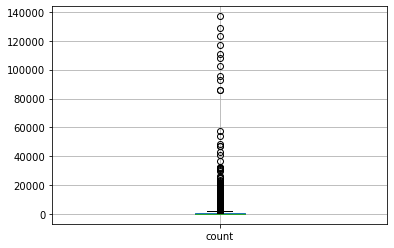

In [23]:
count_df.boxplot(column='count', return_type='axes')